In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from IPython.display import clear_output
from collections import namedtuple, deque

from unityagents import UnityEnvironment

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
from noise import OUNoise
from buffer import ReplayBuffer
from model import ActorCriticNetwork

In [4]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [5]:
plt.style.use('ggplot')

## Set Configs

In [6]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [7]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 512
GAMMA = 0.99
TAU = 1e-3
PRINT_EVERY = 200
UPDATE_EVERY = 2

# actor & critic network have different learning rates
LR_ACTOR = 1e-4
LR_CRITIC = 1e-3
WEIGHT_DECAY = 0.0 # L2 weight decay

# noise settings
NOISE_START = 0.5
NOISE_DECAY = 1.0
TIME_STOP_NOISE = int(3e4)

## Set Environment

In [8]:
env = UnityEnvironment(file_name='./Tennis.app')

brain_name = env.brain_names[0] # get the brain from unity environment
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [9]:
print('Environment Info')
env_info = env.reset(train_mode=False)[brain_name] # reset environment to a new, random state
state = env_info.vector_observations
action_size = brain.vector_action_space_size

print('Number of agents: {}'.format(len(env_info.agents)))
print('State space: {}'.format(state.shape[1]))
print('Action space: {}'.format(action_size))

Environment Info
Number of agents: 2
State space: 24
Action space: 2


## Define [MADDPG](https://arxiv.org/pdf/1706.02275.pdf) Agent

In [10]:
class DDPGAgent():
    """The Agent that will interacts with and learns from the environment."""

    def __init__(self, agent_id, model, state_size, action_size, seed):
        """Initialize an DDPG Agent object."""
        
        self.agent_id = agent_id
        
        self.state_size = state_size
        self.action_size = action_size
        
        self.lr_actor = LR_ACTOR
        self.lr_critic = LR_CRITIC
        self.weight_decay = WEIGHT_DECAY
        self.tau = TAU
        
        # initialize actor and critic networks
        self.actor = model.actor.to(device)
        self.actor_target = model.actor_target.to(device)
        
        self.critic = model.critic.to(device)
        self.critic_target = model.critic_target.to(device)
            
        # set optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.lr_critic, weight_decay=self.weight_decay)
        
        # set weights for local and target actor, respectively, critic the same
        self.soft_update(self.actor, self.actor_target, 1)
        self.soft_update(self.critic, self.critic_target, 1)
        
        # introduce noise process
        self.noise = OUNoise(self.action_size, seed)
        
    def act(self, states, noise_weight=1.0, add_noise=True):
        """Return action for given state as per current policy."""
        
        states = torch.FloatTensor(states).to(device)
        self.actor.eval()
        with torch.no_grad():
            actions = self.actor(states).cpu().data.numpy()
        self.actor.train()
        
        if add_noise==True:
            self.noise_value = self.noise.sample() * noise_weight
            actions += self.noise_value
        
        actions = np.clip(actions, -1, 1)
        
        return actions
    
    def reset(self):
        """Reset noise parameters."""
        self.noise.reset()
        
    def learn(self, agent_id, experiences, gamma, all_actions, all_next_actions):
        """Update policy and value parameters using given batch of experience tuples."""
        
        states, actions, rewards, next_states, dones = experiences
        
        # get the agent id
        agent_id = torch.tensor([agent_id]).to(device)
        
        # obtain Q expected
        Q_expected = self.critic(states, actions)
        
        next_actions = torch.cat(all_next_actions, dim=1).to(device)
        with torch.no_grad():
            Q_target_next = self.critic_target(next_states, next_actions)
        
        # compute Q target
        Q_targets = rewards.index_select(1, agent_id) + (gamma * Q_target_next * (1 - dones.index_select(1, agent_id)))
        
        # compute value loss
        value_loss = F.mse_loss(Q_expected, Q_targets.detach())
        
        # minimize critic loss
        self.critic_optimizer.zero_grad()
        value_loss.backward()
        self.critic_optimizer.step()
        
        # detach actions from other agents
        actions_pred = [actions if i == self.agent_id else actions.detach() for i, actions in enumerate(all_actions)]
        actions_pred = torch.cat(actions_pred, dim=1).to(device)
        
        # update actor
        policy_loss = -self.critic(states, actions_pred).mean()
        
        # minimize policy loss
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()
        
        # softly update target networks
        self.soft_update(self.actor, self.actor_target, self.tau)
        self.soft_update(self.critic, self.critic_target, self.tau)
    
    def soft_update(self, local_model, target_model, tau):
        """Softly update model parameters."""
        
        for local_param, target_param in zip(local_model.parameters(), target_model.parameters()):
            target_param.data.copy_(local_param.data * tau + target_param.data * (1.0 - tau))

In [11]:
class MADDPGAgent():
    """The Agent that will interacts with and learns from the environment."""
    
    def __init__(self, env, num_agents, seed):
        """Initialize an MADDPG Agent object."""
        
        self.brain = env.brains[env.brain_names[0]] # get the brain from unity environment
        
        self.env_info = env.reset(train_mode=True)[brain_name]
                
        self.state_size = env_info.vector_observations.shape[1]
        self.action_size = self.brain.vector_action_space_size
        
        self.num_agents = num_agents
        
        self.buffer_size = BUFFER_SIZE
        self.batch_size = BATCH_SIZE
        self.gamma = GAMMA
        self.noise_weight = NOISE_START
        self.noise_decay = NOISE_DECAY
        self.time_stop_noise = TIME_STOP_NOISE
        self.noise_on = True
        
        # create agents, each with their own actor and critic
        models = [ActorCriticNetwork(self.num_agents, self.state_size, self.action_size, seed) for _ in range(self.num_agents)]
        self.agents = [DDPGAgent(i, models[i], self.state_size, self.action_size, seed) for i in range(self.num_agents)]
        
        # set buffer
        self.buffer = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        self.time_step = 0
        
    def act(self, all_states):
        
        # pass each agent's state from the environment and calculate its action
        all_actions = []
        for agent, state in zip(self.agents, all_states):
            actions = agent.act(state, noise_weight=self.noise_weight, add_noise=self.noise_on)
            self.noise_weight *= self.noise_decay
            all_actions.append(actions)
        
        actions = np.array(all_actions).reshape(1, -1) # reshape 2x2 into 1x4 dimension vector
        
        return actions
        
    def step(self, all_states, all_actions, all_rewards, all_next_states, all_dones):
        
        all_states = all_states.reshape(1, -1) # reshape 2x24 into 1x48 dimension vector
        all_next_states = all_next_states.reshape(1, -1) # reshape 2x24 into 1x48 dimension vector
        
        self.buffer.add(all_states, all_actions, all_rewards, all_next_states, all_dones)
        
        # if time stop noise are achieved then turning off the noise
        if self.time_step > self.time_stop_noise:
            self.noise_on = False
            
        self.time_step += 1     
        
        # learn every UPDATE_EVERY time steps
        if self.time_step % UPDATE_EVERY == 0:
            # if enough samples are available in memory, get random subset and learn
            if len(self.buffer) > BATCH_SIZE:
                
                # sample from the replay buffer of each agent
                experiences = [self.buffer.sample() for _ in range(self.num_agents)]
                self.learn(experiences, self.gamma)
                
    def learn(self, experiences, gamma):
        
        # each agent uses its own actor to calculate next actions
        all_actions = []
        all_next_actions = []

        for i, agent in enumerate(self.agents):
            
            states, _, _, next_states, _ = experiences[i]
            agent_id = torch.tensor([i]).to(device)
            
            # extract agent i's state and get action via actor network
            states = states.reshape(-1, 2, 24).index_select(1, agent_id).squeeze(1)
            actions = agent.actor(states)
            all_actions.append(actions)
            
            # extract agent i's next state and get action via target action network
            next_states = next_states.reshape(-1, 2, 24).index_select(1, agent_id).squeeze(1)
            next_actions = agent.actor_target(next_states)
            all_next_actions.append(next_actions)
            
        # each agent learns from its experience sample
        for i, agent in enumerate(self.agents):
            agent.learn(i, experiences[i], gamma, all_actions, all_next_actions)
    
    def save(self, actor_path, critic_path):
        """Save trained agent."""
        if not os.path.exists('./agents/'): os.makedirs('./agents/')
        
        # save actor and critic for each agent
        for i, agent in enumerate(self.agents):
            torch.save(self.agents[i].actor.state_dict(), f'{actor_path}_agent{i}.pth'); torch.save(self.agents[i].critic.state_dict(), f'{critic_path}_agent{i}.pth')
            
    def load(self, actor_path):
        """Load trained agent."""
        for i, agent in enumerate(self.agents):
            self.agents[i].actor.load_state_dict(torch.load(f'{actor_path}_agent{i}.pth'))
            
    def watch(self, num_episodes=10, max_time=1000):
        """Watch trained agent."""
        
        for i_episode in range(1, num_episodes+1):

            all_rewards_A = []
            all_rewards_B = []
            
            env_info = env.reset(train_mode=False)[brain_name]
            states = env_info.vector_observations

            for time_step in range(max_time):

                actions = agent.act(states)
                env_info = env.step(actions)[brain_name]
                next_states, rewards, dones = env_info.vector_observations, env_info.rewards, env_info.local_done
                
                agent.step(states, actions, rewards, next_states, dones)
                states = next_states
                
                rewards_B, rewards_A = rewards
                all_rewards_A.append(rewards_A)
                all_rewards_B.append(rewards_B)
                
                if any(dones):
                    break
                    
            episode_reward_A = np.max(np.sum(np.array(all_rewards_A), axis=0))
            episode_reward_B = np.max(np.sum(np.array(all_rewards_B), axis=0))
            
            if episode_reward_A > episode_reward_B:
                print(f'\rEpisode: {i_episode}, Reward A: {episode_reward_A:.3f}, Reward B: {episode_reward_B:.3f}, Agent A is win.')
            else:
                print(f'\rEpisode: {i_episode}, Reward A: {episode_reward_A:.3f}, Reward B: {episode_reward_B:.3f}, Agent B is win.')

In [12]:
agent = MADDPGAgent(env, num_agents=2, seed=90)

## Train The Agent

In [13]:
def train_agent(num_episodes=5000, max_time=1000):
    """Train MADDPG agent."""
    
    all_scores = []
    scores_target = 0.5
    scores_window = deque(maxlen=PRINT_EVERY)
    
    for i_episode in range(1, num_episodes+1):
        
        all_rewards = []
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        for time_step in range(max_time):
            
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states, rewards, dones = env_info.vector_observations, env_info.rewards, env_info.local_done
            
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            all_rewards.append(rewards)
            if any(dones):
                break
        
        # calculate episode reward as maximum of individually collected rewards of agents
        episode_reward = np.max(np.sum(np.array(all_rewards), axis=0))
        
        all_scores.append(episode_reward) # save most recent score to overall score
        scores_window.append(episode_reward) # save most recent score to running window of last window scores
        
        print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.3f}', end='')
        
        if i_episode % PRINT_EVERY == 0:
            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.3f}')
        if np.mean(scores_window) >= scores_target:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes! Average Score: {np.mean(scores_window):.3f}')
            break
            
    agent.save(f'./agents/ACTOR_{brain_name}', f'./agents/CRITIC_{brain_name}')
    print('Training completed.')
    
    return all_scores

In [14]:
all_scores = train_agent(num_episodes=5000, max_time=1000)

Episode: 200, Average Score: 0.007
Episode: 400, Average Score: 0.004
Episode: 600, Average Score: 0.020
Episode: 800, Average Score: 0.014
Episode: 1000, Average Score: 0.022
Episode: 1200, Average Score: 0.089
Episode: 1400, Average Score: 0.074
Episode: 1600, Average Score: 0.097
Episode: 1800, Average Score: 0.104
Episode: 2000, Average Score: 0.103
Episode: 2200, Average Score: 0.108
Episode: 2400, Average Score: 0.452
Episode: 2421, Average Score: 0.503
Environment solved in 2321 episodes! Average Score: 0.503
Training completed.


## Evaluate The Agent

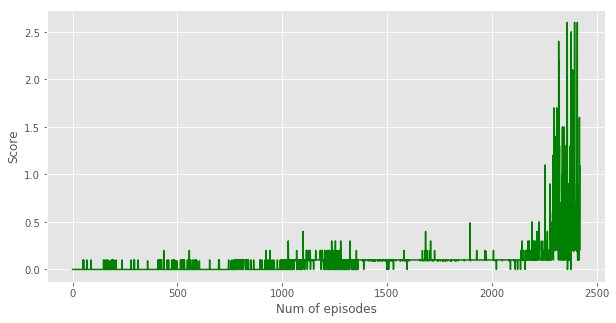

In [15]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(all_scores)), all_scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_maddpg_evaluation.png')
plt.show()

## 🎬 Watch The Agent

In [16]:
agent.load(f'./agents/ACTOR_{brain_name}');

In [17]:
agent.watch(num_episodes=10)

Episode: 1, Reward A: 0.790, Reward B: 0.700, Agent A is win.
Episode: 2, Reward A: 1.390, Reward B: 1.400, Agent B is win.
Episode: 3, Reward A: 0.100, Reward B: -0.010, Agent A is win.
Episode: 4, Reward A: 1.000, Reward B: 0.990, Agent A is win.
Episode: 5, Reward A: 2.600, Reward B: 2.600, Agent B is win.
Episode: 6, Reward A: 1.200, Reward B: 1.090, Agent A is win.
Episode: 7, Reward A: 0.490, Reward B: 0.600, Agent B is win.
Episode: 8, Reward A: 0.200, Reward B: 0.190, Agent A is win.
Episode: 9, Reward A: 0.390, Reward B: 0.300, Agent A is win.
Episode: 10, Reward A: 2.600, Reward B: 2.500, Agent A is win.


---